#### Final Season Rankings

In [103]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [104]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../data/initial_data/awards_players.csv")
coaches = pd.read_csv("../data/initial_data/coaches.csv")
players_teams = pd.read_csv("../data/initial_data/players_teams.csv")
players = pd.read_csv("../data/initial_data/players.csv")
series_post = pd.read_csv("../data/initial_data/series_post.csv")
teams_post = pd.read_csv("../data/initial_data/teams_post.csv")
teams = pd.read_csv("../data/initial_data/teams.csv")

In [105]:
# ================================
# GET PLAYERS FOR TEAM
# ================================
def get_players_for_team(players_teams_df, year, team_id):
    """Return all players who played for a specific team in a given year."""
    return players_teams_df[
        (players_teams_df["year"] == year) &
        (players_teams_df["tmID"] == team_id)
    ].copy()

In [106]:
# ================================
# PLAYER GAME SCORE
# ================================
def get_player_game_score(players_teams_df, player_id, year):
    """
    Compute a player's game score for a given year.
    Returns a clean Python dictionary.
    """
    df_player = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ].copy()

    if df_player.empty:
        return {
            "playerID": player_id,
            "year": year,
            "tmID": None,
            "Game_Score_Total": None,
            "Game_Score_Per_Game": None,
            "Game_Score_Per_Minute": None
        }

    # Base game score formula
    base_score = (
        df_player["points"]
        + 0.4 * df_player["fgMade"]
        - 0.7 * df_player["fgAttempted"]
        - 0.4 * (df_player["ftAttempted"] - df_player["ftMade"])
        + 0.7 * df_player["oRebounds"]
        + 0.3 * df_player["dRebounds"]
        + df_player["steals"]
        + 0.7 * df_player["assists"]
        + 0.7 * df_player["blocks"]
        - 0.4 * df_player["PF"]
        - df_player["turnovers"]
    )

    df_player["Game_Score_Total"] = base_score
    df_player["Game_Score_Per_Game"] = base_score / df_player["GP"].replace(0, np.nan)
    df_player["Game_Score_Per_Minute"] = base_score / df_player["minutes"].replace(0, np.nan)

    return {
        "playerID": player_id,
        "year": int(year),
        "tmID": ",".join(df_player["tmID"].unique()),
        "Game_Score_Total": float(df_player["Game_Score_Total"].sum(skipna=True)),
        "Game_Score_Per_Game": float(df_player["Game_Score_Per_Game"].mean(skipna=True)),
        "Game_Score_Per_Minute": float(df_player["Game_Score_Per_Minute"].mean(skipna=True)),
    }



In [107]:
# ================================
# TEAM WEIGHTED GAME SCORE
# ================================
def get_team_weighted_avg_score(players_teams_df, year, team_id):
    """
    Weighted average = mean player GameScorePerMinute weighted by GameScoreTotal.
    Uses prior-year stats (year-1), which is correct for prediction models.
    """
    df_team = get_players_for_team(players_teams_df, year, team_id)

    if df_team.empty:
        return {
            "tmID": team_id,
            "year": year,
            "Team_Weighted_Avg_Per_Minute": None,
            "Num_Players": 0
        }

    player_scores = []
    for player_id in df_team["playerID"].unique():
        player_scores.append(get_player_game_score(players_teams_df, player_id, year - 1))

    df_scores = pd.DataFrame(player_scores)

    total_weight = df_scores["Game_Score_Total"].sum(skipna=True)
    if not total_weight or np.isnan(total_weight):
        weighted_avg = None
    else:
        weighted_avg = (
            (df_scores["Game_Score_Per_Minute"] * df_scores["Game_Score_Total"]).sum(skipna=True)
            / total_weight
        )

    return {
        "tmID": team_id,
        "year": year,
        "Team_Weighted_Avg_Per_Minute": float(weighted_avg) if weighted_avg is not None else None,
        "Num_Players": int(len(df_scores))
    }


In [108]:
# ================================
# CONFERENCE RANKINGS
# ================================
def get_conference_rankings(players_teams_df, teams_df, year):
    """
    Predict conference rankings using team weighted scores.
    Returns (Eastern_df, Western_df).
    """
    teams_year = teams_df[teams_df["year"] == year][[
        "tmID", "confID", "name", "rank", "won", "lost"
    ]].copy()

    if teams_year.empty:
        print(f"No team data found for year {year}.")
        return pd.DataFrame(), pd.DataFrame()

    teams_year.rename(columns={"rank": "Actual_Rank"}, inplace=True)

    # Compute weighted score for each team
    team_results = [
        get_team_weighted_avg_score(players_teams_df, year, tm)
        for tm in teams_year["tmID"].unique()
    ]

    df_scores = pd.DataFrame(team_results)
    df_scores = df_scores.merge(teams_year, on="tmID", how="left")

    # Rank within each conference
    df_scores["Predicted_Rank_Conf"] = (
        df_scores.groupby("confID")["Team_Weighted_Avg_Per_Minute"]
        .rank(ascending=False, method="first")
    )

    df_scores["Rank_Diff"] = (
        df_scores["Predicted_Rank_Conf"] - df_scores["Actual_Rank"]
    )

    # Separate conferences
    east_df = df_scores[df_scores["confID"] == "EA"].sort_values("Predicted_Rank_Conf").reset_index(drop=True)
    west_df = df_scores[df_scores["confID"] == "WE"].sort_values("Predicted_Rank_Conf").reset_index(drop=True)

    return east_df, west_df

In [109]:
# ================================
# EXAMPLE
# ================================
east_rankings, west_rankings = get_conference_rankings(players_teams, teams, year=10)

print("\n🏀 EASTERN CONFERENCE")
print(east_rankings)

print("\n🏀 WESTERN CONFERENCE")
print(west_rankings)


🏀 EASTERN CONFERENCE
  tmID  year  Team_Weighted_Avg_Per_Minute  Num_Players confID  \
0  CON    10                      0.318042           14     EA   
1  DET    10                      0.301598           18     EA   
2  CHI    10                      0.291838           12     EA   
3  NYL    10                      0.288212           11     EA   
4  ATL    10                      0.281187           13     EA   
5  IND    10                      0.273435           14     EA   
6  WAS    10                      0.232280           12     EA   

                 name  Actual_Rank  won  lost  Predicted_Rank_Conf  Rank_Diff  
0     Connecticut Sun            6   16    18                  1.0       -5.0  
1       Detroit Shock            3   18    16                  2.0       -1.0  
2         Chicago Sky            5   16    18                  3.0       -2.0  
3    New York Liberty            7   13    21                  4.0       -3.0  
4       Atlanta Dream            2   18    16    

## Predicative Model PipeLine 

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.linear_model import Ridge


# ======================================================

# HELPER FUNCTIONS

# ======================================================



def get_players_for_team(players_teams_df, year, team_id):

    return players_teams_df[

        (players_teams_df["year"] == year) &

        (players_teams_df["tmID"] == team_id)

    ].copy()





def calculate_player_score(df):

    """Apply your Game Score formula to a DataFrame of players."""

    base = (

        df["points"]

        + 0.4 * df["fgMade"]

        - 0.7 * df["fgAttempted"]

        - 0.4 * (df["ftAttempted"] - df["ftMade"])

        + 0.7 * df["oRebounds"]

        + 0.3 * df["dRebounds"]

        + df["steals"]

        + 0.7 * df["assists"]

        + 0.7 * df["blocks"]

        - 0.4 * df["PF"]

        - df["turnovers"]

    )



    df["Game_Score_Total"] = base

    df["Game_Score_Per_Minute"] = base / df["minutes"].replace(0, np.nan)

    return df





# Map previous season's team ID accounting for franchise relocations

def get_prev_tmID(teams_df, year, current_tmID):

    prev_year = year - 1

    # First try same tmID

    prev_same = teams_df[(teams_df["year"] == prev_year) & (teams_df["tmID"] == current_tmID)]

    if not prev_same.empty:

        return current_tmID

    # Fallback: match by franchID if available

    this_row = teams_df[(teams_df["year"] == year) & (teams_df["tmID"] == current_tmID)]

    if this_row.empty or "franchID" not in teams_df.columns:

        return current_tmID

    franch = this_row.iloc[0]["franchID"]

    prev_franch = teams_df[(teams_df["year"] == prev_year) & (teams_df["franchID"] == franch)]

    if not prev_franch.empty:

        return prev_franch.iloc[0]["tmID"]

    return current_tmID





def get_team_weighted_score(players_teams_df, year, team_id, teams_df=None):

    """Weighted avg player score using previous season, handling relocations via teams_df."""

    prev_tmID = team_id if teams_df is None else get_prev_tmID(teams_df, year, team_id)

    df = get_players_for_team(players_teams_df, year - 1, prev_tmID)

    if df.empty:

        return None, 0



    df = calculate_player_score(df)



    total_weight = df["Game_Score_Total"].sum(skipna=True)

    if total_weight == 0 or np.isnan(total_weight):

        return None, len(df)



    weighted_avg = (

        (df["Game_Score_Per_Minute"] * df["Game_Score_Total"]).sum()

        / total_weight

    )



    return float(weighted_avg), len(df)





def get_team_continuity(players_teams_df, year, tmID, teams_df=None):

    """Fraction of players returning from previous year, handling relocations via teams_df."""

    prev_tmID = tmID if teams_df is None else get_prev_tmID(teams_df, year, tmID)

    prev_players = set(players_teams_df[(players_teams_df["year"] == year-1) & (players_teams_df["tmID"] == prev_tmID)]["playerID"])

    curr_players = set(players_teams_df[(players_teams_df["year"] == year) & (players_teams_df["tmID"] == tmID)]["playerID"])

    if not prev_players or not curr_players:

        return 0

    return len(prev_players & curr_players) / len(prev_players)





def get_coach_win_pct(coaches_df, teams_df, year, tmID):

    """Coach historical win pct before given year."""

    df = coaches_df[(coaches_df["tmID"] == tmID) & (coaches_df["year"] < year)]

    if df.empty:

        return 0

    wins, games = 0, 0

    for _, row in df.iterrows():

        team_row = teams_df[(teams_df["tmID"] == tmID) & (teams_df["year"] == row["year"]) ]

        if not team_row.empty:

            wins += team_row.iloc[0]["won"]

            games += team_row.iloc[0]["GP"]

    return wins / max(games, 1)





def get_coach_features(coaches_df, tmID, year):

    """Return coach experience and whether a coach changed from prev season."""

    df = coaches_df[coaches_df["tmID"] == tmID]



    this_year = df[df["year"] == year]

    prev_year = df[df["year"] == year - 1]



    if this_year.empty:

        return 0, 0



    coach_id = this_year["coachID"].iloc[0]



    # Experience = total seasons coached before this year

    experience = len(

        df.loc[(df["coachID"] == coach_id) & (df["year"] < year)]

    )



    # Coach change?

    changed = int(prev_year.empty or prev_year["coachID"].iloc[0] != coach_id)



    return experience, changed





def evaluate_spearman(df):

    return spearmanr(df["Actual_Rank"], df["Predicted_Rank"]).correlation





def top_k_accuracy(df, k=1):

    actual_top_k = set(df.sort_values("Actual_Rank").head(k)["tmID"])

    predicted_top_k = set(df.sort_values("Predicted_Rank").head(k)["tmID"])

    return len(actual_top_k & predicted_top_k) / k





def evaluate_kendall(df):

    return kendalltau(df["Actual_Rank"], df["Predicted_Rank"]).correlation





def evaluate_year_predictions(df):

    results = {}



    for conf in ["EA", "WE"]:

        conf_df = df[df["confID"] == conf].copy()



        spearman = evaluate_spearman(conf_df)

        kendall = evaluate_kendall(conf_df)

        top1 = top_k_accuracy(conf_df, k=1)

        top3 = top_k_accuracy(conf_df, k=3)

        mae = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"])

        rmse = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))



        results[conf] = {

            "Spearman": spearman,

            "KendallTau": kendall,

            "Top1_Accuracy": top1,

            "Top3_Accuracy": top3,

            "MAE": mae,

            "RMSE": rmse,

        }



    return results





# ======================================================

# BUILD TRUE PRESEASON TRAINING DATASET (year Y label, year Y-1 features)

# ======================================================

rows = []



all_years = sorted(teams["year"].unique())



for year in all_years:

    # We cannot build preseason features for the first season

    prev_year = year - 1

    prev_teams = teams[teams["year"] == prev_year]



    for _, row in teams[teams["year"] == year].iterrows():

        tmID = row["tmID"]



        # Get previous-year roster weighted score (relocation-aware)

        wscore, num_players = get_team_weighted_score(players_teams, year, tmID, teams_df=teams)



        # Continuity = between prev_year and year (relocation-aware)

        continuity = get_team_continuity(players_teams, year, tmID, teams_df=teams)



        # Previous season team stats (fallback via franchID handled in helper for players, here stay by tmID)

        prev_team = prev_teams[prev_teams["tmID"] == get_prev_tmID(teams, year, tmID)]

        if prev_team.empty:

            continue



        prev = prev_team.iloc[0]



        prev_winpct = prev["won"] / max(prev["GP"], 1)

        prev_pf = prev["o_pts"]

        prev_pa = prev["d_pts"]



        # Coach historical win pct *before* this year

        coach_win = get_coach_win_pct(coaches, teams, year, tmID)



        rows.append({

            "year": year,

            "tmID": tmID,

            "confID": row["confID"],

            "Actual_Rank": row["rank"],   # TARGET = rank of upcoming season



            # Features from year-1

            "WeightedScore": wscore,

            "Continuity": continuity,

            "PrevWinPct": prev_winpct,

            "PrevPointsFor": prev_pf,

            "PrevPointsAgainst": prev_pa,

            "CoachWinPct": coach_win

        })



    dataset = pd.DataFrame(rows).dropna()

    dataset.to_csv("preseason_training_data.csv", index=False)



    print(dataset.head())





# ======================================================

# PREPARE ML INPUTS

# ======================================================

feature_cols = [

    "WeightedScore",

    "Continuity",

    "PrevWinPct", 

    "PrevPointsFor", 

    "PrevPointsAgainst", 

    "CoachWinPct"

]



X = dataset[feature_cols]

y = dataset["Actual_Rank"]



X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, shuffle=True, random_state=42

)



# ======================================================

# TRAIN RIDGE MODEL

# ======================================================

model = Ridge(alpha=1.0, random_state=42)



model.fit(X_train, y_train)



preds = model.predict(X_test)



mae = mean_absolute_error(y_test, preds)

rmse = np.sqrt(mean_squared_error(y_test, preds))



print("Model Performance:")

print("MAE:", mae)

print("RMSE:", rmse)





# ======================================================

# FEATURE IMPORTANCE / COEFFICIENTS

# ======================================================

if hasattr(model, "feature_importances_"):

    feat_imp = pd.DataFrame({

        "Feature": feature_cols,

        "Importance": model.feature_importances_

    }).sort_values("Importance", ascending=False)

else:

    coefs = np.array(model.coef_)

    # Use absolute value of coefficients as importance proxy

    importance = np.abs(coefs)

    # Normalize to sum to 1 for readability

    importance = importance / importance.sum() if importance.sum() != 0 else importance

    feat_imp = pd.DataFrame({

        "Feature": feature_cols,

        "Importance": importance

    }).sort_values("Importance", ascending=False)



feat_imp.to_csv("feature_importances.csv", index=False)

print("Saved feature_importances.csv")

print(feat_imp)





# ======================================================

# PREDICT RANKINGS FOR A SPECIFIC YEAR

# ======================================================

def preseason_predict_conference_rankings(year, players_teams_df, teams_df, coaches_df, model, feature_cols):

    """

    Predict preseason conference rankings for a given season

    using only historical data (previous seasons).

    

    Returns:

        east_df, west_df: DataFrames with tmID, predicted rank, and features

    """

    rows = []



    # Get all teams for the target year

    teams_this_year = teams_df[teams_df["year"] == year]

    if teams_this_year.empty:

        raise ValueError(f"No team data found for year {year}.")



    for _, row in teams_this_year.iterrows():

        tmID = row["tmID"]



        # Features from historical data (relocation-aware)

        wscore, num_players = get_team_weighted_score(players_teams_df, year, tmID, teams_df=teams_df)

        continuity = get_team_continuity(players_teams_df, year, tmID, teams_df=teams_df)

        

        prev_tmID = get_prev_tmID(teams_df, year, tmID)

        prev_team = teams_df[(teams_df["tmID"] == prev_tmID) & (teams_df["year"] == year - 1)]

        if prev_team.empty:

            prev_winpct = 0

            prev_pts_for = 0

            prev_pts_against = 0

        else:

            prev = prev_team.iloc[0]

            prev_winpct = prev["won"] / max(prev["GP"], 1)

            prev_pts_for = prev["o_pts"]

            prev_pts_against = prev["d_pts"]



        coach_win = get_coach_win_pct(coaches_df, teams_df, year, tmID)



        rows.append({

            "tmID": tmID,

            "confID": row["confID"],

            "WeightedScore": wscore,

            "Continuity": continuity,

            "PrevWinPct": prev_winpct,

            "PrevPointsFor": prev_pts_for,

            "PrevPointsAgainst": prev_pts_against,

            "CoachWinPct": coach_win

        })



    pred_df = pd.DataFrame(rows).dropna()

    # Predict ranks

    pred_df["Predicted_Rank"] = model.predict(pred_df[feature_cols])

    pred_df = pred_df.sort_values("Predicted_Rank")



    east_df = pred_df[pred_df["confID"] == "EA"].copy()

    west_df = pred_df[pred_df["confID"] == "WE"].copy()



    return east_df, west_df





# Example usage

east, west = preseason_predict_conference_rankings(

    year=8,  # next season

    players_teams_df=players_teams,

    teams_df=teams,

    coaches_df=coaches,

    model=model,

    feature_cols=feature_cols

)



print("\nPredicted EAST:")

print(east)



print("\nPredicted WEST:")

print(west)



Empty DataFrame
Columns: []
Index: []
   year tmID confID  Actual_Rank  WeightedScore  Continuity  PrevWinPct  \
0     2  CHA     EA            4       0.265591    0.384615     0.25000   
1     2  CLE     EA            1       0.242527    0.846154     0.53125   
2     2  DET     EA            7       0.250346    0.538462     0.43750   
3     2  HOU     WE            4       0.355958    0.583333     0.84375   
4     2  IND     EA            6       0.260149    0.466667     0.28125   

   PrevPointsFor  PrevPointsAgainst  CoachWinPct  
0           2186               2429      0.25000  
1           2185               2122      0.53125  
2           2331               2426      0.43750  
3           2475               2066      0.84375  
4           2213               2290      0.28125  
   year tmID confID  Actual_Rank  WeightedScore  Continuity  PrevWinPct  \
0     2  CHA     EA            4       0.265591    0.384615     0.25000   
1     2  CLE     EA            1       0.242527    0.84

Saved correlation_spearman.csv and correlation_pearson.csv
Spearman correlation (preview):
                   WeightedScore  Continuity  PrevWinPct  PrevPointsFor  \
WeightedScore              1.000       0.029       0.599          0.766   
Continuity                 0.029       1.000       0.307         -0.110   
PrevWinPct                 0.599       0.307       1.000          0.340   
PrevPointsFor              0.766      -0.110       0.340          1.000   
PrevPointsAgainst          0.367      -0.320      -0.202          0.795   
CoachWinPct                0.343       0.226       0.644          0.200   
Actual_Rank               -0.281       0.013      -0.366         -0.243   

                   PrevPointsAgainst  CoachWinPct  Actual_Rank  
WeightedScore                  0.367        0.343       -0.281  
Continuity                    -0.320        0.226        0.013  
PrevWinPct                    -0.202        0.644       -0.366  
PrevPointsFor                  0.795        0.20

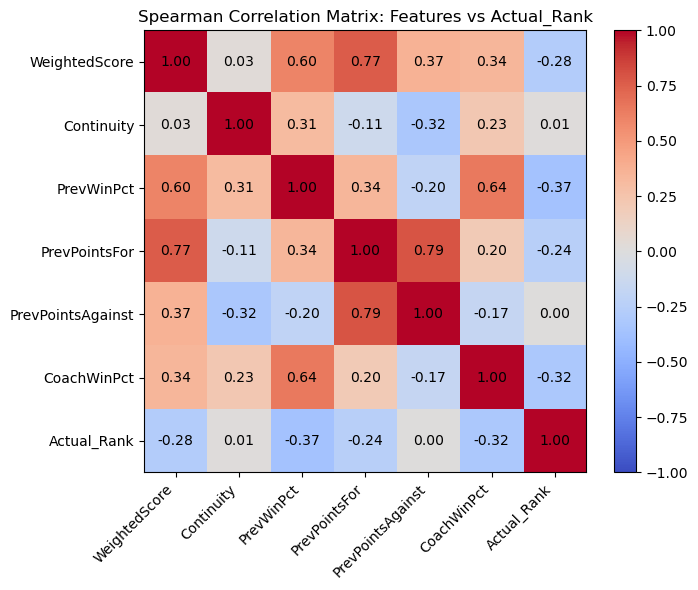

In [111]:
# ================================
# FEATURE/TARGET CORRELATION MATRIX
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Select engineered features + target
corr_cols = feature_cols + ["Actual_Rank"]
subset = dataset[corr_cols].copy()

# Compute Spearman correlation (robust for rankings/ordinal target)
spearman_corr = subset.corr(method="spearman")

# Also compute Pearson for comparison (optional)
pearson_corr = subset.corr(method="pearson")

# Save to CSV for reference
spearman_corr.to_csv("correlation_spearman.csv")
pearson_corr.to_csv("correlation_pearson.csv")

print("Saved correlation_spearman.csv and correlation_pearson.csv")
print("Spearman correlation (preview):")
print(spearman_corr.round(3))

# Plot Spearman correlation heatmap
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(spearman_corr.values, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_title("Spearman Correlation Matrix: Features vs Actual_Rank")
ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

# Annotate cells
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = spearman_corr.values[i, j]
        ax.text(j, i, f"{val:.2f}", va="center", ha="center", color="black")

fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()

## Evaluating the Model


=== RandomForest Rolling Averages ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.5  0.345536    0.285714  1.655644  1.935305          0.375   
1     WE   6.5  0.392560    0.319048  1.540761  1.789915          0.500   

   Top3_Accuracy  
0       0.625000  
1       0.583333  

=== ExtraTrees Rolling Averages ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.5  0.163095    0.139286  1.733974  2.065105           0.00   
1     WE   6.5  0.354464    0.313690  1.567289  1.836421           0.25   

   Top3_Accuracy  
0       0.541667  
1       0.583333  

=== GradientBoosting Rolling Averages ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.5  0.234226    0.182738  1.973184  2.234129           0.50   
1     WE   6.5  0.282738    0.204167  1.830170  2.245203           0.25   

   Top3_Accuracy  
0       0.541667  
1       0.541667  

=== SVR(RBF) Rolling Averages =

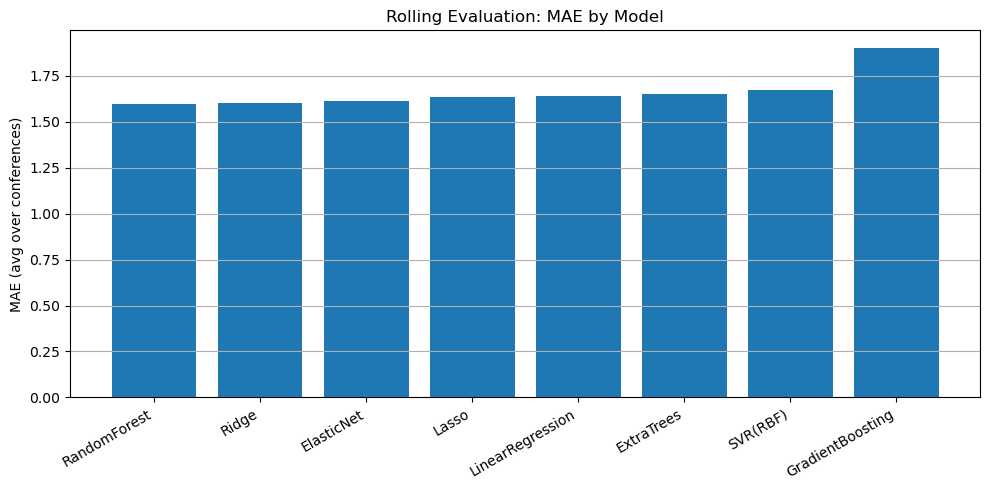

In [112]:
# ===============================================
# MODEL COMPARISON: multiple regressors, rolling eval
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Define candidate models with sensible defaults
candidate_models = {
    "RandomForest": RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, min_samples_leaf=3, max_features="sqrt", bootstrap=True, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=600, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features="sqrt", bootstrap=False, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR(RBF)": SVR(kernel="rbf", C=3.0, epsilon=0.2, gamma="scale"),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.001, random_state=42, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000),
}

years_sorted = sorted(dataset["year"].unique())

def rolling_eval_for_model(model, feature_cols, dataset):
    results = []
    for year in years_sorted:
        past_years = [y for y in years_sorted if y < year]
        if len(past_years) == 0:
            continue
        train_df = dataset[dataset["year"].isin(past_years)].copy()
        test_df  = dataset[dataset["year"] == year].copy()
        if train_df.empty or test_df.empty:
            continue
        # Fit
        model.fit(train_df[feature_cols], train_df["Actual_Rank"]) 
        # Predict
        test_df["Predicted_Rank"] = model.predict(test_df[feature_cols])
        # Metrics per conference
        for conf in ["EA", "WE"]:
            conf_df = test_df[test_df["confID"] == conf].copy()
            if conf_df.empty:
                continue
            spearman = spearmanr(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            kendall  = kendalltau(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            mae      = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]) 
            rmse     = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))
            # Top-k
            actual_top1    = set(conf_df.sort_values("Actual_Rank").head(1)["tmID"]) 
            predicted_top1 = set(conf_df.sort_values("Predicted_Rank").head(1)["tmID"]) 
            top1 = int(bool(actual_top1 & predicted_top1))
            actual_top3    = set(conf_df.sort_values("Actual_Rank").head(3)["tmID"]) 
            predicted_top3 = set(conf_df.sort_values("Predicted_Rank").head(3)["tmID"]) 
            top3 = len(actual_top3 & predicted_top3) / 3.0
            results.append({"Year": year, "confID": conf, "Spearman": spearman, "KendallTau": kendall, "MAE": mae, "RMSE": rmse, "Top1_Accuracy": top1, "Top3_Accuracy": top3})
    return pd.DataFrame(results)

# Run rolling evaluation for each model
comparison = {}
for name, mdl in candidate_models.items():
    df = rolling_eval_for_model(mdl, feature_cols, dataset)
    comparison[name] = df.groupby("confID").mean(numeric_only=True).reset_index()
    # Save per-model results
    # df.to_csv(f"evaluation_rolling_{name}_by_year.csv", index=False)
    # comparison[name].to_csv(f"evaluation_rolling_{name}_averages.csv", index=False)
    print(f"\n=== {name} Rolling Averages ===")
    print(comparison[name])

# Summary table: average across conferences (weighted equally)
summary_rows = []
for name, avg_df in comparison.items():
    # mean over conferences for each metric
    row = {"Model": name}
    for metric in ["Spearman", "KendallTau", "MAE", "RMSE", "Top1_Accuracy", "Top3_Accuracy", "Year"]:
        if metric in avg_df.columns:
            row[metric] = avg_df[metric].mean()
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values(["MAE", "RMSE"], ascending=[True, True])
summary_df.to_csv("evaluation_rolling_model_summary.csv", index=False)
print("\n=== Rolling Model Comparison (lower MAE/RMSE is better) ===")
print(summary_df)

# Plot MAE by model (average over conferences)
plt.figure(figsize=(10,5))
plt.bar(summary_df["Model"], summary_df["MAE"]) 
plt.ylabel("MAE (avg over conferences)")
plt.title("Rolling Evaluation: MAE by Model")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Saved evaluation_rolling_by_year.csv

=== Rolling Evaluation (Train on past, predict next) ===
   Year confID  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     3     EA  0.071429    0.071429  2.205195  2.521745              0   
1     3     WE  0.523810    0.428571  1.651345  1.891120              1   
2     4     EA -0.571429   -0.523810  2.089060  2.457697              0   
3     4     WE  0.714286    0.619048  1.393319  1.463535              1   
4     5     EA  0.200000    0.066667  1.581782  1.838014              0   

   Top3_Accuracy  
0       0.333333  
1       0.666667  
2       0.333333  
3       0.666667  
4       0.666667  

=== Rolling Averages by Conference ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.5  0.180357    0.126786  1.640516  1.906395          0.375   
1     WE   6.5  0.505655    0.392857  1.558587  1.776608          0.500   

   Top3_Accuracy  
0       0.541667  
1       0.583333  


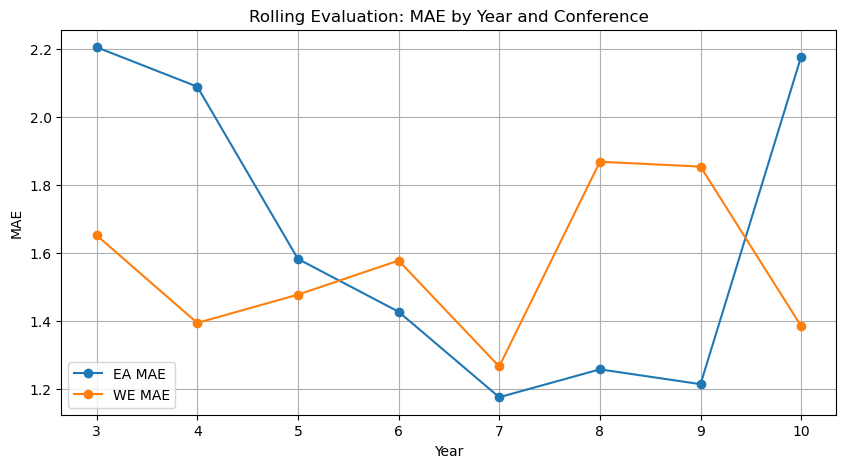

In [113]:
# ===============================================
# ROLLING EVALUATION: train on past, predict next
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau

# Years available in dataset
years_sorted = sorted(dataset["year"].unique())
rolling_results = []

for year in years_sorted:
    past_years = [y for y in years_sorted if y < year]
    if len(past_years) == 0:
        # need at least one past season to train
        continue

    train_df = dataset[dataset["year"].isin(past_years)].copy()
    test_df  = dataset[dataset["year"] == year].copy()
    if train_df.empty or test_df.empty:
        continue

    # Train new model on past years only
    roll_model = Ridge(alpha=1.0, random_state=42)
    roll_model.fit(train_df[feature_cols], train_df["Actual_Rank"]) 

    # Predict current year
    test_df["Predicted_Rank"] = roll_model.predict(test_df[feature_cols])

    # Metrics per conference
    for conf in ["EA", "WE"]:
        conf_df = test_df[test_df["confID"] == conf].copy()
        if conf_df.empty:
            continue
        spearman = spearmanr(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
        kendall  = kendalltau(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
        mae      = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]) 
        rmse     = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))
        # Top-k accuracies
        actual_top1 = set(conf_df.sort_values("Actual_Rank").head(1)["tmID"]) 
        predicted_top1 = set(conf_df.sort_values("Predicted_Rank").head(1)["tmID"]) 
        top1_acc = len(actual_top1 & predicted_top1)
        actual_top3 = set(conf_df.sort_values("Actual_Rank").head(3)["tmID"]) 
        predicted_top3 = set(conf_df.sort_values("Predicted_Rank").head(3)["tmID"]) 
        top3_acc = len(actual_top3 & predicted_top3) / 3.0

        rolling_results.append({
            "Year": year,
            "confID": conf,
            "Spearman": spearman,
            "KendallTau": kendall,
            "MAE": mae,
            "RMSE": rmse,
            "Top1_Accuracy": top1_acc,
            "Top3_Accuracy": top3_acc,
        })

# Collate and save
rolling_df = pd.DataFrame(rolling_results)
rolling_df.to_csv("evaluation_rolling_by_year.csv", index=False)
print("Saved evaluation_rolling_by_year.csv")
print("\n=== Rolling Evaluation (Train on past, predict next) ===")
print(rolling_df.head())

# Averages
rolling_avg = rolling_df.groupby("confID").mean(numeric_only=True).reset_index()
rolling_avg.to_csv("evaluation_rolling_averages.csv", index=False)
print("\n=== Rolling Averages by Conference ===")
print(rolling_avg)

# Plot MAE over years by conference
plt.figure(figsize=(10,5))
for conf in ["EA", "WE"]:
    conf_df = rolling_df[rolling_df["confID"] == conf]
    plt.plot(conf_df["Year"], conf_df["MAE"], marker="o", label=f"{conf} MAE")
plt.title("Rolling Evaluation: MAE by Year and Conference")
plt.xlabel("Year")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.show()



=== Average Metrics Across All Years ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.0  0.239947    0.164550  1.634837  1.871841       0.333333   
1     WE   6.0  0.547354    0.441799  1.539505  1.742013       0.444444   

   Top3_Accuracy  
0       0.555556  
1       0.629630  

 OVERFITTING CHECK: Train vs Test
Train MAE: 1.541
Test  MAE: 1.877
Gap      : 0.336
⚠️ Mild Overfitting.

 GROUP K-FOLD CROSS-VALIDATION (YEAR-BY-YEAR)
Fold 1: Train MAE = 1.582, Test MAE = 1.689
Fold 2: Train MAE = 1.572, Test MAE = 1.847
Fold 3: Train MAE = 1.600, Test MAE = 1.581
Fold 4: Train MAE = 1.581, Test MAE = 1.647
Fold 5: Train MAE = 1.664, Test MAE = 1.438

 CROSS-VALIDATION SUMMARY
Avg Train MAE: 1.600
Avg Test  MAE: 1.641
Gap         : 0.041


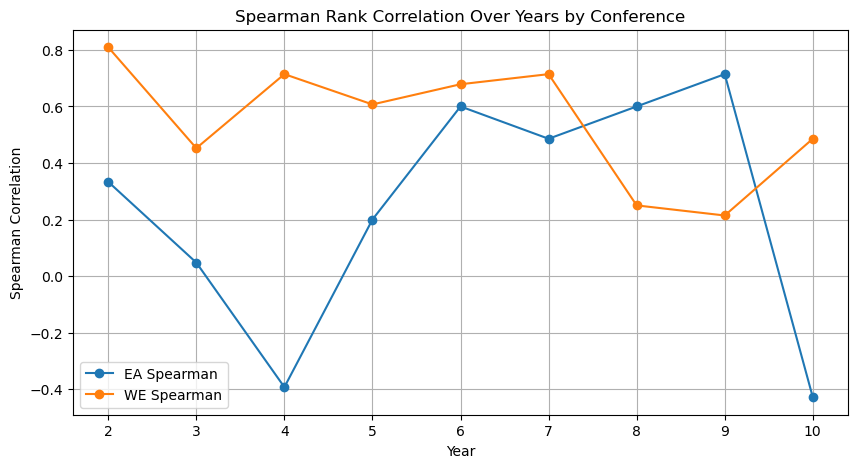

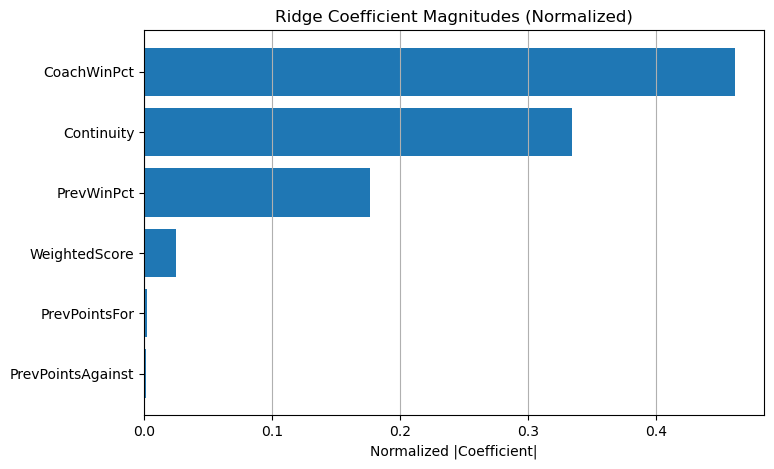

In [ ]:
# ======================================================
# COMPREHENSIVE MODEL EVALUATION FUNCTION
# ======================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau
from sklearn.model_selection import GroupKFold

def top_k_accuracy(df, k=1):
    """Compute top-k accuracy for rankings."""
    actual_top_k = set(df.sort_values("Actual_Rank").head(k)["tmID"])
    predicted_top_k = set(df.sort_values("Predicted_Rank").head(k)["tmID"])
    return len(actual_top_k & predicted_top_k) / k

def evaluate_comprehensive(dataset, feature_cols, model, save_path_prefix="evaluation"):
    results_all = []

    # --------------------------
    # Predict per year
    # --------------------------
    for year in sorted(dataset["year"].unique()):
        df_year = dataset[dataset["year"] == year].copy()
        if df_year.empty:
            continue
        df_year["Predicted_Rank"] = model.predict(df_year[feature_cols])

        for conf in ["EA", "WE"]:
            conf_df = df_year[df_year["confID"] == conf].copy()
            if conf_df.empty:
                continue

            spearman = spearmanr(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            kendall = kendalltau(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            mae = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"])
            rmse = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))
            top1 = top_k_accuracy(conf_df, k=1)
            top3 = top_k_accuracy(conf_df, k=3)

            results_all.append({
                "Year": year,
                "confID": conf,
                "Spearman": spearman,
                "KendallTau": kendall,
                "MAE": mae,
                "RMSE": rmse,
                "Top1_Accuracy": top1,
                "Top3_Accuracy": top3
            })

    # --------------------------
    # Save detailed results
    # --------------------------
    results_df = pd.DataFrame(results_all)
    results_df.to_csv(f"{save_path_prefix}_by_year.csv", index=False)

    # Average metrics per conference
    avg_df = results_df.groupby("confID").mean(numeric_only=True).reset_index()
    avg_df.to_csv(f"{save_path_prefix}_averages.csv", index=False)
    
    print("\n=== Average Metrics Across All Years ===")
    print(avg_df)

    # --------------------------
    # Overfitting Check: Train vs Test
    # --------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        dataset[feature_cols], dataset["Actual_Rank"], test_size=0.2, shuffle=True, random_state=42
    )
    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae  = mean_absolute_error(y_test, test_preds)
    print("\n===============================")
    print(" OVERFITTING CHECK: Train vs Test")
    print("===============================")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test  MAE: {test_mae:.3f}")
    gap = test_mae - train_mae
    print(f"Gap      : {gap:.3f}")
    if gap > 1.0:
        print("⚠️ Strong Overfitting Detected!")
    elif gap > 0.3:
        print("⚠️ Mild Overfitting.")
    else:
        print("✅ No significant overfitting.")

    # --------------------------
    # GroupKFold CV by Year
    # --------------------------
    gkf = GroupKFold(n_splits=5)
    cv_train_mae, cv_test_mae = [], []
    print("\n===============================")
    print(" GROUP K-FOLD CROSS-VALIDATION (YEAR-BY-YEAR)")
    print("===============================")
    X_full = dataset[feature_cols]
    y_full = dataset["Actual_Rank"]
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full, groups=dataset["year"])):
        X_tr, X_te = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_tr, y_te = y_full.iloc[train_idx], y_full.iloc[test_idx]

        model.fit(X_tr, y_tr)
        preds_tr = model.predict(X_tr)
        preds_te = model.predict(X_te)
        mae_tr = mean_absolute_error(y_tr, preds_tr)
        mae_te = mean_absolute_error(y_te, preds_te)
        cv_train_mae.append(mae_tr)
        cv_test_mae.append(mae_te)
        print(f"Fold {fold+1}: Train MAE = {mae_tr:.3f}, Test MAE = {mae_te:.3f}")

    print("\n===============================")
    print(" CROSS-VALIDATION SUMMARY")
    print("===============================")
    print(f"Avg Train MAE: {np.mean(cv_train_mae):.3f}")
    print(f"Avg Test  MAE: {np.mean(cv_test_mae):.3f}")
    print(f"Gap         : {np.mean(cv_test_mae) - np.mean(cv_train_mae):.3f}")

    # --------------------------
    # Plot Spearman over years
    # --------------------------
    plt.figure(figsize=(10,5))
    for conf in ["EA", "WE"]:
        conf_df = results_df[results_df["confID"] == conf]
        plt.plot(conf_df["Year"], conf_df["Spearman"], marker="o", label=f"{conf} Spearman")
    plt.title("Spearman Rank Correlation Over Years by Conference")
    plt.xlabel("Year")
    plt.ylabel("Spearman Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Feature Importance / Coefficients
    if hasattr(model, "feature_importances_"):
        feat_imp = pd.DataFrame({
            "Feature": feature_cols,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)
        plt.figure(figsize=(8,5))
        plt.barh(feat_imp["Feature"], feat_imp["Importance"])
        plt.title("Model Feature Importance")
        plt.xlabel("Importance")
        plt.gca().invert_yaxis()
        plt.grid(axis="x")
        plt.show()
    elif hasattr(model, "coef_"):
        coefs = np.array(model.coef_)
        importance = np.abs(coefs)
        importance = importance / importance.sum() if importance.sum() != 0 else importance
        feat_imp = pd.DataFrame({
            "Feature": feature_cols,
            "Importance": importance
        }).sort_values("Importance", ascending=False)
        plt.figure(figsize=(8,5))
        plt.barh(feat_imp["Feature"], feat_imp["Importance"])
        plt.title("Ridge Coefficient Magnitudes (Normalized)")
        plt.xlabel("Normalized |Coefficient|")
        plt.gca().invert_yaxis()
        plt.grid(axis="x")
        plt.show()
    else:
        feat_imp = pd.DataFrame({"Feature": feature_cols, "Importance": np.nan})

    return results_df, avg_df, feat_imp

results_df, avg_df, feat_imp = evaluate_comprehensive(dataset, feature_cols, model)

In [115]:
# ===============================================
# PREDICT SEASON 11 USING TEST + HISTORICAL DATA (RELOCATION-AWARE)
# ===============================================
import pandas as pd

# Load test data (season 11 inputs)
test_coaches = pd.read_csv("../data/test_data/coaches.csv")
test_players_teams = pd.read_csv("../data/test_data/players_teams.csv")
test_teams = pd.read_csv("../data/test_data/teams.csv")

# Load historical (initial) data for previous seasons
hist_coaches = pd.read_csv("../data/initial_data/coaches.csv")
hist_players_teams = pd.read_csv("../data/initial_data/players_teams.csv")
hist_teams = pd.read_csv("../data/initial_data/teams.csv")

# Combine: historical up to year 10 + test for year 11
combined_coaches = pd.concat([hist_coaches, test_coaches], ignore_index=True)
combined_players_teams = pd.concat([hist_players_teams, test_players_teams], ignore_index=True)
combined_teams = pd.concat([hist_teams, test_teams], ignore_index=True)

# Ensure types are consistent for joins/lookups
for df in [combined_coaches, combined_players_teams, combined_teams]:
    if "year" in df.columns:
        df["year"] = df["year"].astype(int)
    if "tmID" in df.columns:
        df["tmID"] = df["tmID"].astype(str)

# Use the trained model (Ridge) and relocation-aware feature functions with combined data
east_11, west_11 = preseason_predict_conference_rankings(
    year=11,
    players_teams_df=combined_players_teams,
    teams_df=combined_teams,
    coaches_df=combined_coaches,
    model=model,
    feature_cols=feature_cols
)

print("\nSeason 11 — Predicted EAST:")
print(east_11)

print("\nSeason 11 — Predicted WEST:")
print(west_11)

# Save predictions
east_11.to_csv("season11_predicted_east.csv", index=False)
west_11.to_csv("season11_predicted_west.csv", index=False)
print("Saved season11_predicted_east.csv and season11_predicted_west.csv")


Season 11 — Predicted EAST:
   tmID confID  WeightedScore  Continuity  PrevWinPct  PrevPointsFor  \
3   IND     EA       0.302155    0.357143    0.647059         2606.0   
2   CON     EA       0.283938    0.142857    0.470588         2651.0   
0   ATL     EA       0.321487    0.538462    0.529412         2861.0   
11  WAS     EA       0.259135    0.333333    0.470588         2585.0   
6   NYL     EA       0.269689    0.363636    0.382353         2512.0   
1   CHI     EA       0.289500    0.333333    0.470588         2573.0   

    PrevPointsAgainst  CoachWinPct  Predicted_Rank  
3              2501.0     0.502994        3.045064  
2              2654.0     0.600840        3.104594  
0              2797.0     0.323529        3.127160  
11             2622.0     0.421659        3.628826  
6              2535.0     0.500000        3.679753  
1              2693.0     0.345588        3.971762  

Season 11 — Predicted WEST:
   tmID confID  WeightedScore  Continuity  PrevWinPct  PrevPointsF